## <center> Building interpretable boosted scorecards </center>

In [ ]:
%%capture
!pip install -r requirements.txt

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import shap

In [2]:
import boosted_scorecard
from get_credit_scores import get_credit_scores

### Data preprocessing

In [3]:
# FICO Explainable Machine Learning Challenge dataset
data = pd.read_csv('heloc_dataset_v1.csv')
data['RiskPerformance'].replace({'Good': 0, 'Bad': 1}, inplace=True)

In [4]:
# Source: http://gnpalencia.org/optbinning/tutorials/tutorial_binning_process_FICO_update_binning.html
binning_fit_params = {
    "ExternalRiskEstimate": {"monotonic_trend": "descending"},
    "MSinceOldestTradeOpen": {"monotonic_trend": "descending"},
    "MSinceMostRecentTradeOpen": {"monotonic_trend": "descending"},
    "AverageMInFile": {"monotonic_trend": "descending"},
    "NumSatisfactoryTrades": {"monotonic_trend": "descending"},
    "NumTrades60Ever2DerogPubRec": {"monotonic_trend": "ascending"},
    "NumTrades90Ever2DerogPubRec": {"monotonic_trend": "ascending"},
    "PercentTradesNeverDelq": {"monotonic_trend": "descending"},
    "MSinceMostRecentDelq": {"monotonic_trend": "descending"},
    "NumTradesOpeninLast12M": {"monotonic_trend": "ascending"},
    "MSinceMostRecentInqexcl7days": {"monotonic_trend": "descending"},
    "NumInqLast6M": {"monotonic_trend": "ascending"},
    "NumInqLast6Mexcl7days": {"monotonic_trend": "ascending"},
    "NetFractionRevolvingBurden": {"monotonic_trend": "ascending"},
    "NetFractionInstallBurden": {"monotonic_trend": "ascending"},
    "NumBank2NatlTradesWHighUtilization": {"monotonic_trend": "ascending"}
}

In [5]:
# create monotonic constraints
feature_trends = pd.DataFrame(binning_fit_params).T.reset_index()
feature_trends.replace({'descending': -1, 'ascending': 1}, inplace=True)
feature_trends.rename({'index': 'feature'}, axis=1, inplace=True)

dictionary = {'feature': [], 'value':[]}

# treat special codes in a prudent way
for feature in feature_trends['feature'].unique():
    if data[feature].isin([-9, -8, -7]).any():
        correlation = data[feature].corr(data['RiskPerformance'])
        if correlation > 0:
            replace_value = data[feature].max()
            data[feature] = np.where(data[feature].isin([-9, -8, -7]), replace_value, data[feature])
        else:
            replace_value = data[feature][data[feature].apply(lambda x: x not in [-9, -8, -7])].min()
            data[feature] = np.where(data[feature].isin([-9, -8, -7]), replace_value, data[feature])

In [6]:
feature_trends[0:5]

,feature,monotonic_trend
0,ExternalRiskEstimate,-1
1,MSinceOldestTradeOpen,-1
2,MSinceMostRecentTradeOpen,-1
3,AverageMInFile,-1
4,NumSatisfactoryTrades,-1


### Data preparation

In [7]:
import time
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [8]:
# define features and monotonic constraints
features = feature_trends['feature'].to_list()
mc = str(feature_trends['monotonic_trend'].to_list())[1:-1]

In [9]:
# features and target
X = data[features + ['RiskPerformance']].copy()
y = X.pop('RiskPerformance')

# sampling (train / test / hold-out)
ix_train_full, ix_test = train_test_split(
    X.index,
    stratify=y, 
    test_size=0.2, 
    random_state=24)

ix_train, ix_val = train_test_split(
    X.loc[ix_train_full].index, 
    stratify=y.loc[ix_train_full], 
    test_size=0.25, 
    random_state=24)

print(f"Train: {len(ix_train):,.0f}\nTest: {len(ix_test):,.0f}\nValidation: {len(ix_val):,.0f}")

Train: 6,275
Test: 2,092
Validation: 2,092


### Scoring function

In [10]:
val_metrics = ['auc', 'logloss']

base_score = y.loc[ix_train].mean().item()

params = {
    'base_score': base_score,
    'learning_rate': 0.2,
    'n_estimators': 50, 
    'max_depth': 1,
    'monotone_constraints': f'({mc})',
    'eval_metric': val_metrics,
    'early_stopping_rounds': 5,
    'tree_method': 'hist',
    'random_state': 24,
}

# train and validation sets
eval_set = [(X.loc[ix_train], y.loc[ix_train]), 
            (X.loc[ix_test], y.loc[ix_test])]

start_time = time.time()

xgb_model = XGBClassifier(**params)

xgb_model.fit(
    X.loc[ix_train], 
    y.loc[ix_train], 
    eval_set=eval_set,
    verbose=False)

execution_time = time.time() - start_time
print(f"Training time: {execution_time:.4f} seconds")

preds = xgb_model.predict_proba(X.loc[ix_val])[:, 1]
gini = roc_auc_score(y.loc[ix_val], preds)*2-1
print(f"Hold-out Gini: {gini:.2%}")

bstr = xgb_model.get_booster()
print(f"Number of trees: {bstr.best_iteration}")

Training time: 0.1568 seconds
Hold-out Gini: 51.30%
Number of trees: 45


### Scorecard

In [26]:
# generate a scorecard
scorecard = boosted_scorecard.generate_scorecard(bstr, base_rate=y.loc[ix_train].mean().item())

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [27]:
# show first two trees
scorecard[scorecard.index <= 1]

,Feature,Sign,Split,Inc_Missing,XAddEvidence,Score,Points
Tree,,,,,,,
0,ExternalRiskEstimate,<,74.0,0,0.134515,0.134515,0
0,ExternalRiskEstimate,>=,74.0,1,-0.196790,-0.196790,24
1,ExternalRiskEstimate,<,71.0,0,0.134740,0.134740,0
1,ExternalRiskEstimate,>=,71.0,1,-0.134625,-0.134625,19


Execution time: 0.1461 seconds


<Axes: >

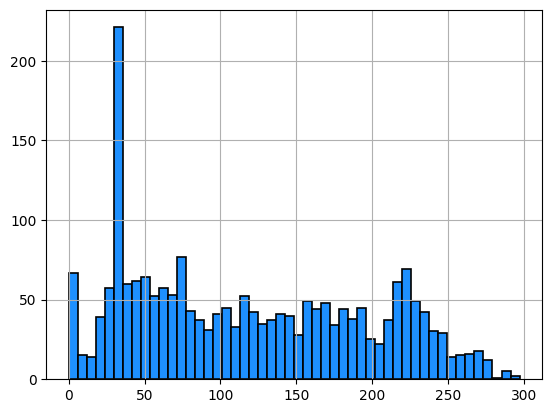

In [32]:
# get credit scores
start_time = time.time()

val_scores = get_credit_scores(df=X.loc[ix_val], 
                               features=X.columns.to_list(),
                               scorecard=scorecard)
# Calculate the execution time
execution_time = time.time() - start_time

print(f"Execution time: {execution_time:.4f} seconds")

# plot credit score distribution
val_scores['Score'].hist(bins=50, color='dodgerblue',
                         edgecolor='black', linewidth=1.2)

In [34]:
# higher score lower DR
pd.concat(
    [val_scores['Score'], y.loc[val_scores.index]], 
    axis=1).corr().unstack()[1:2].item()

-0.4520726657158727

### Feature importances

In [35]:
import shap
import matplotlib.pyplot as plt

#### Custom boosted scorecard importances

In [36]:
# higher score higher DR
test_df = pd.concat([val_scores['Score'], y.loc[val_scores.index]], axis=1)
print(f"Gini scorecard: {roc_auc_score(test_df['RiskPerformance'], -test_df['Score'])*2-1:.2%}")
print(f"Gini XGBoost: {roc_auc_score(y.loc[ix_val], xgb_model.predict_proba(X.loc[ix_val])[:,1])*2-1:.2%}")

Gini scorecard: 51.26%
Gini XGBoost: 51.30%


In [37]:
feats = val_scores.columns.to_list()
feats.remove('Score')

importances = {'Feature': [], 'Importance': []}

for feat in feats:
    importance = val_scores[feat].mean()
    importances['Feature'].append(feat)
    importances['Importance'].append(importance)

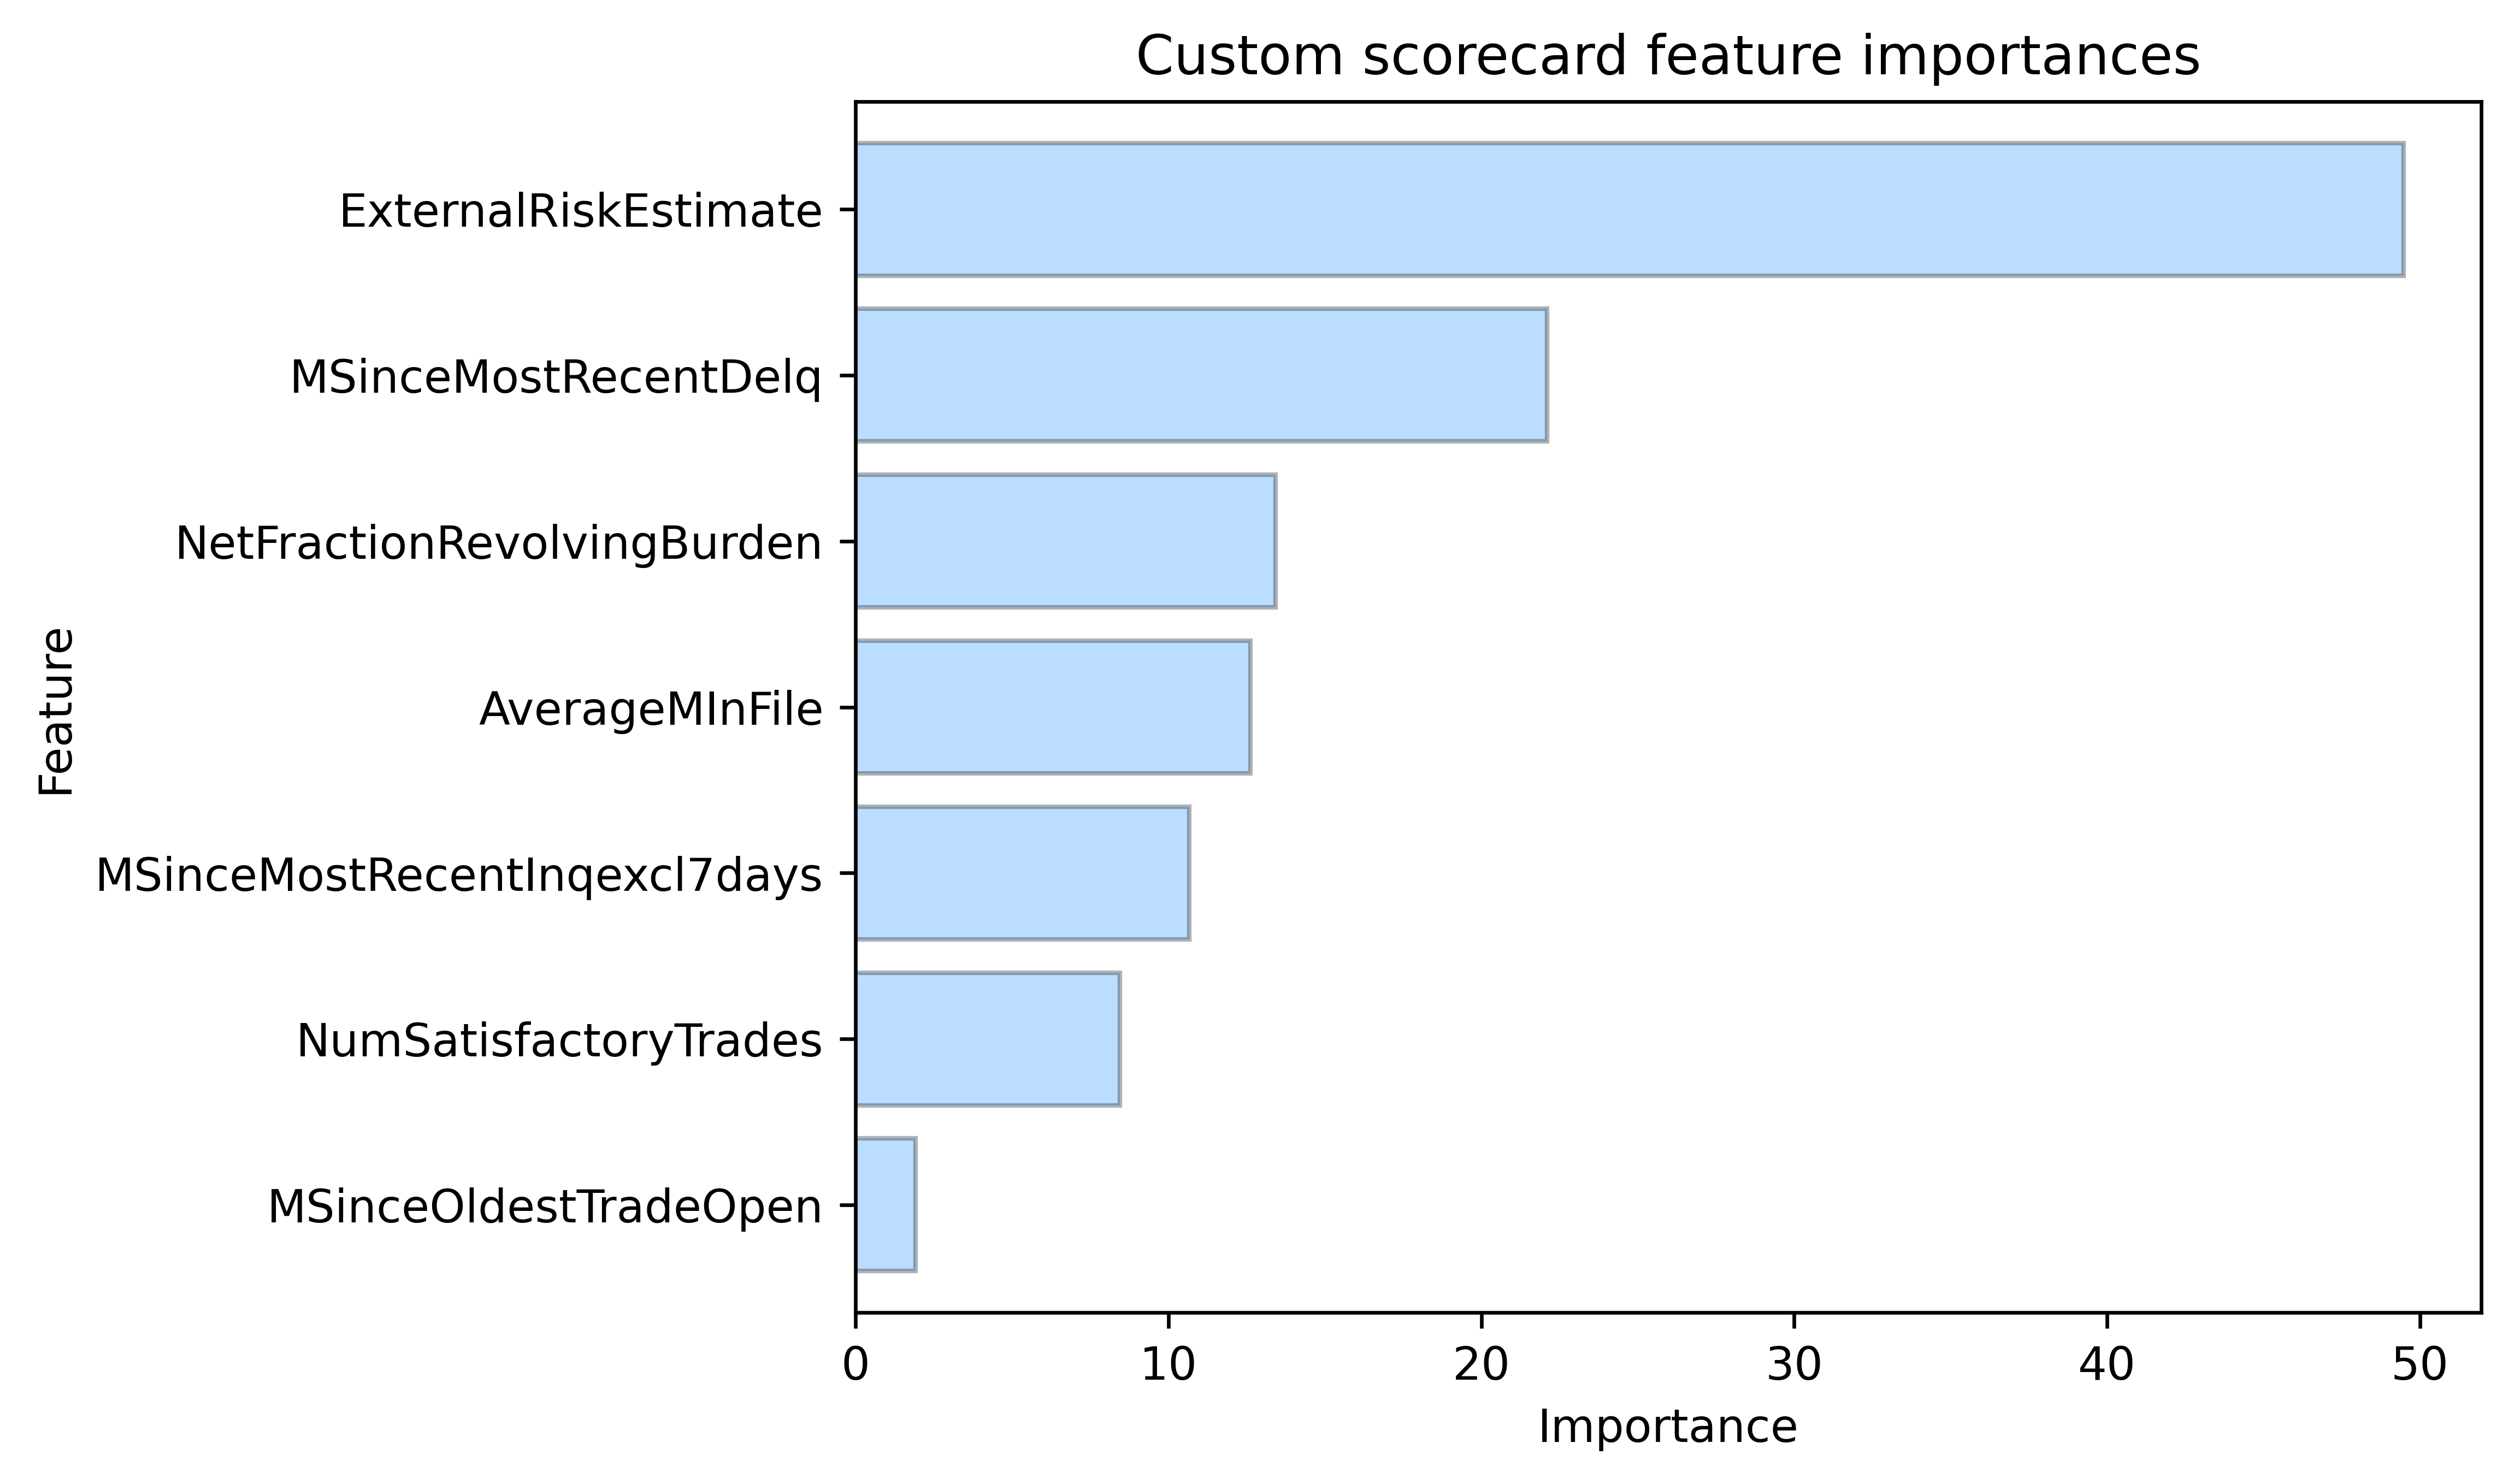

In [48]:
bstr_importances = pd.DataFrame(importances).sort_values(by='Importance', ascending=True)
# select top 7 features
bstr_importances_top = bstr_importances.sort_values(by='Importance', ascending=False)[0:7]
top_imp = bstr_importances_top.iloc[:,0].to_list()

fig = plt.figure(dpi=600)
bstr_importances[bstr_importances['Feature'].isin(top_imp)].plot(
    title='Custom scorecard feature importances', kind='barh', width=0.8, 
    color='dodgerblue', alpha=0.3, x='Feature', legend=False, xlabel='Importance',
    edgecolor='black', ax = plt.gca())
fig.savefig('custom_importance.png', bbox_inches='tight')

#### SHAP importances

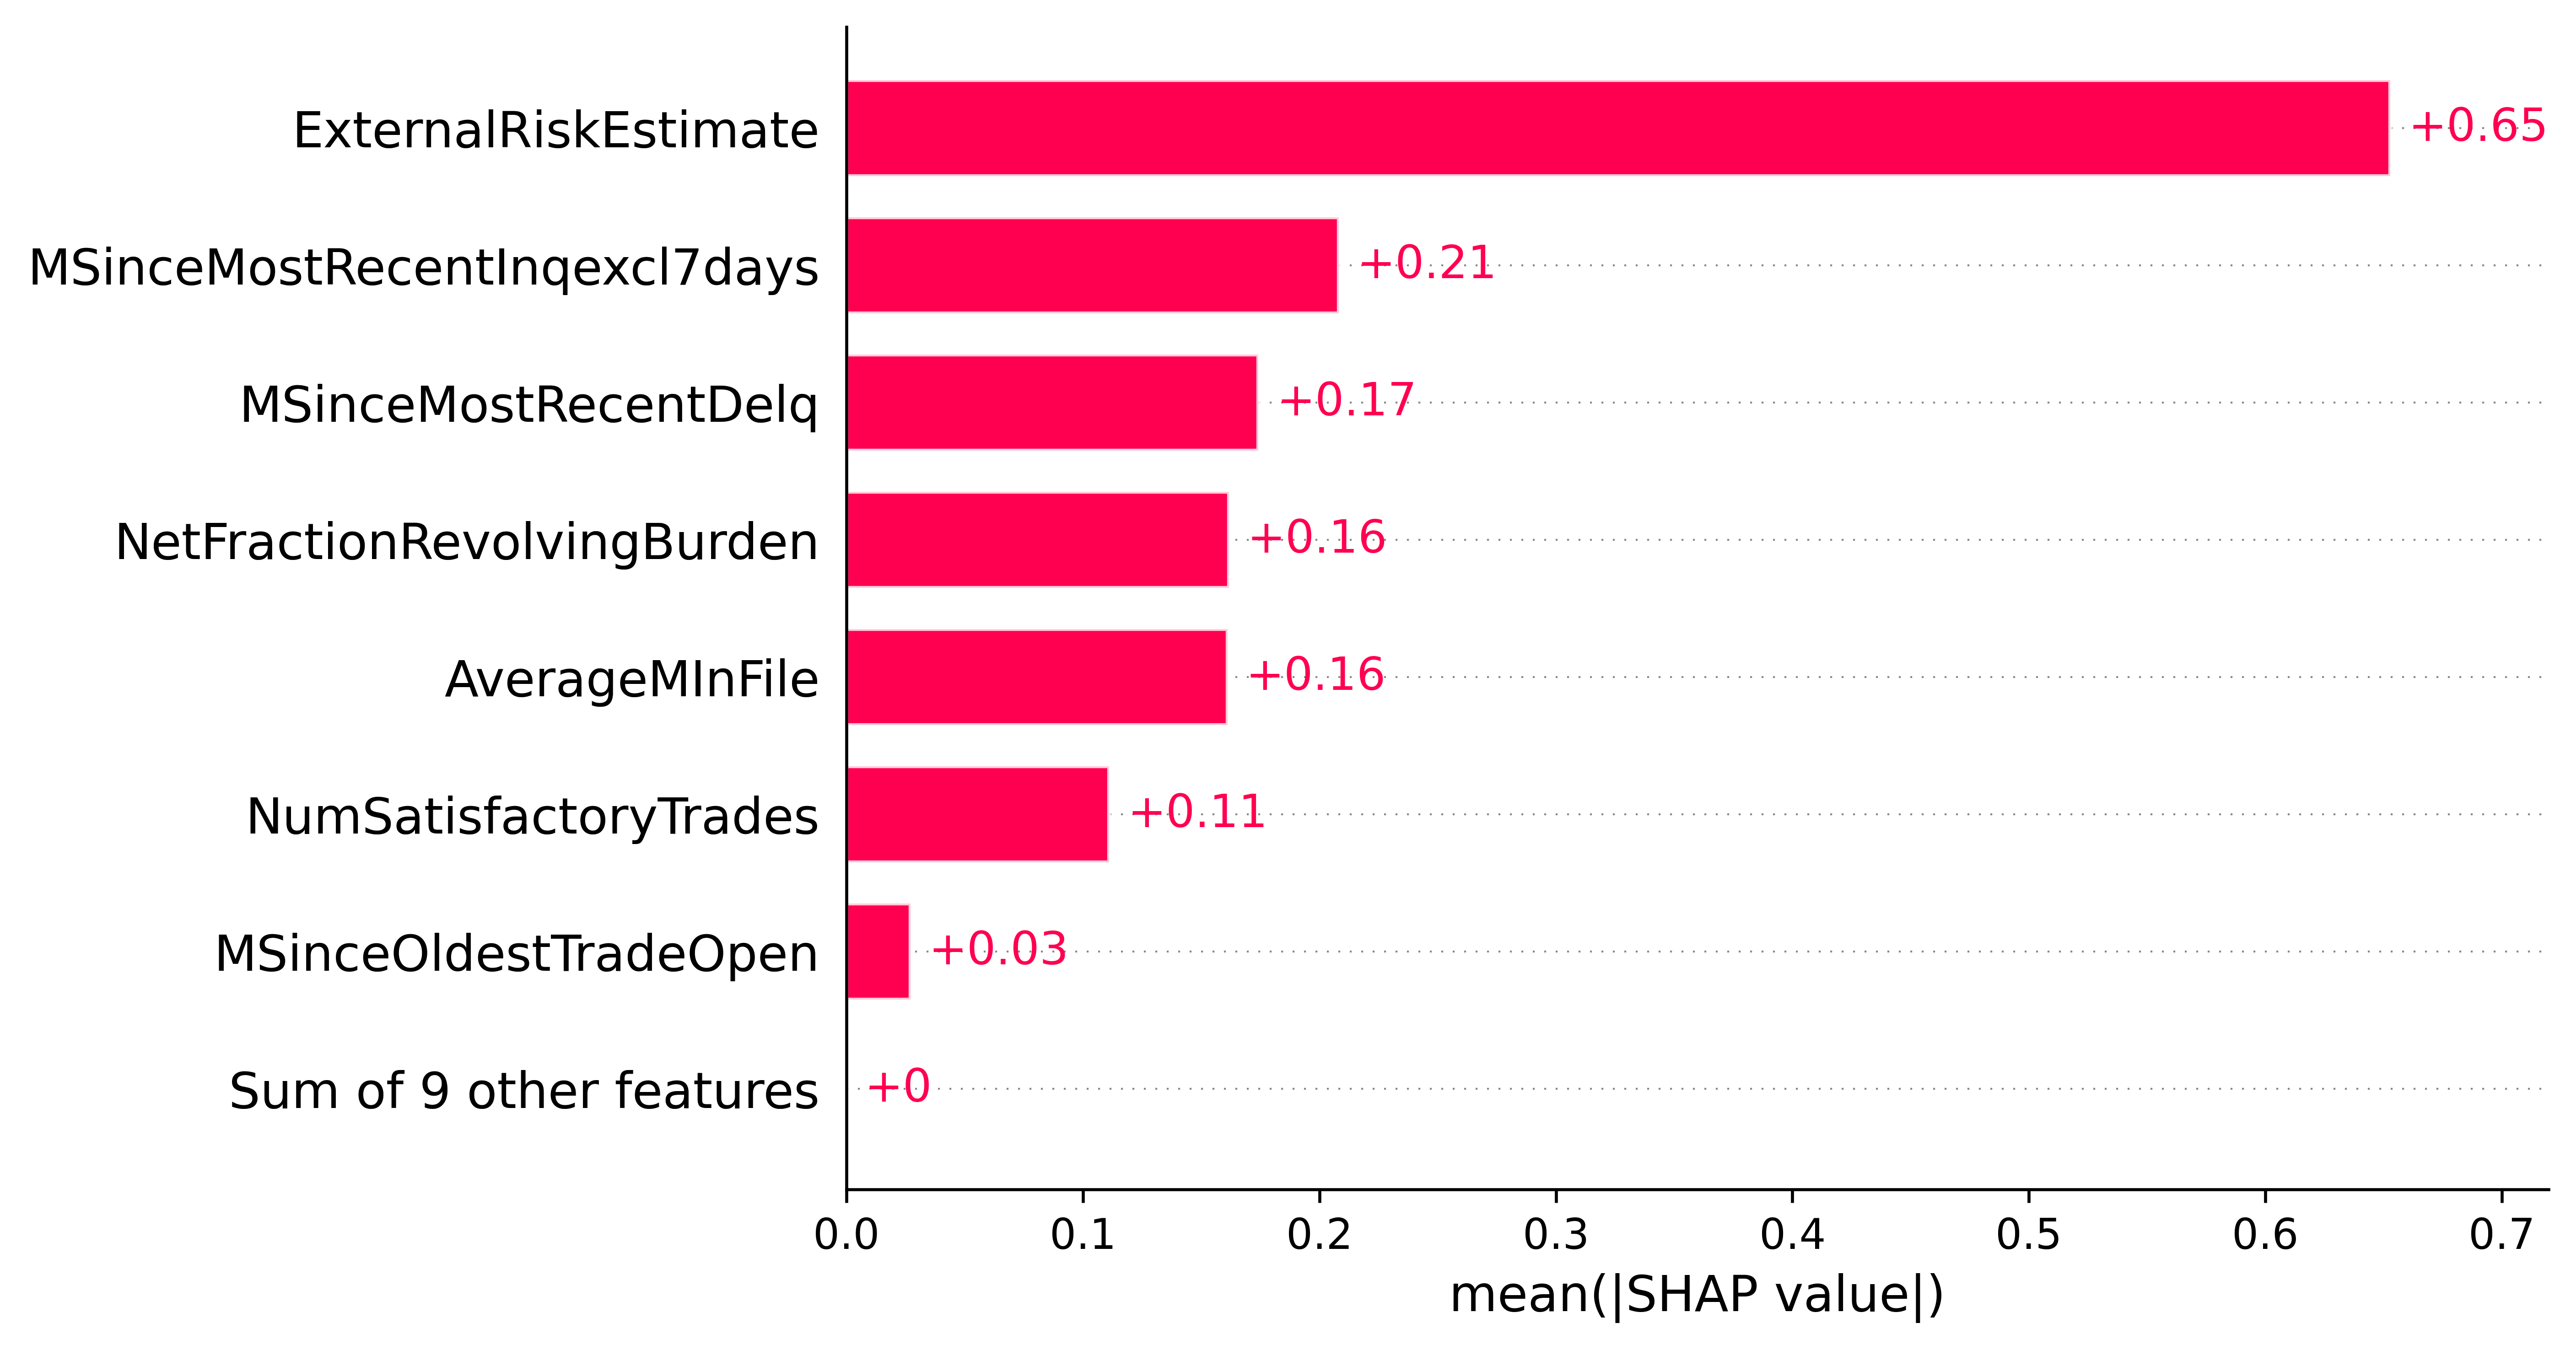

In [47]:
explainer = shap.Explainer(xgb_model, X.loc[ix_test])
shap_values = explainer(X.loc[ix_test])

fig=plt.figure(dpi=600)
shap.plots.bar(shap_values, max_display=8, show=False)
fig.savefig('shap_importance.png', bbox_inches='tight')